# Data Modelling for Departures

### Load Libraries
Load the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,recall_score,precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
metar_decoded_engineered = pd.read_csv('../data/metar_decoded_engineered.csv')
metar_decoded_engineered.head()

,Unnamed: 0,AIRPORT_IATA,Date,Hour,Wind_direction_imp,Wind_speed_imp,Temperature_imp,Dew_point_imp,Pressure_imp
0,0,LHR,2019-05-18,23,10.0,3.0,11.0,9.0,1009.0
1,1,LHR,2019-05-18,23,20.0,2.0,10.0,8.0,1009.0
2,2,LHR,2019-05-18,22,40.0,2.0,12.0,9.0,1009.0
3,3,LHR,2019-05-18,22,60.0,2.0,12.0,9.0,1008.0
4,4,LHR,2019-05-18,21,360.0,2.0,13.0,9.0,1008.0


In [4]:
metar_decoded_engineered = metar_decoded_engineered.drop('Unnamed: 0',axis=1)

In [5]:
len(metar_decoded_engineered)

13477

In [6]:
len(metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour']))

8211

In [7]:
weather_parameters_mean = pd.DataFrame({
    'Wind_direction' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Wind_direction_imp'].mean(),
    'Wind_speed' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Wind_speed_imp'].mean(),
    'Temperature' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Temperature_imp'].mean(),
    'Dew_point' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Dew_point_imp'].mean(),
    'Pressure' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Pressure_imp'].mean()}).reset_index()

In [8]:
departures_extended = pd.read_csv('../data/departures_extended_egineered.csv')

In [9]:
departure_merge = pd.merge(departures_extended, weather_parameters_mean, how='inner', left_on=['flight_origin_code_iata','Date_departures','Hour_departures'], right_on=['AIRPORT_IATA','Date','Hour'])
departure_merge.head()

,Unnamed: 0,index,mode,flight_number,airline_name,airline_iata,flight_origin_code_iata,flight_origin_name,flight_destination_code_iata,flight_destination_name,...,Hour_arrivals,Date_arrivals,AIRPORT_IATA,Date,Hour,Wind_direction,Wind_speed,Temperature,Dew_point,Pressure
0,0,145495,departures,AF1081,Air France,AF,LHR,London Heathrow Airport,CDG,Paris Charles de Gaulle Airport,...,7,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0
1,1,145496,departures,BA472,British Airways,BA,LHR,London Heathrow Airport,BCN,Barcelona El Prat Airport,...,8,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0
2,2,145497,departures,TP1363,TAP Air Portugal,TP,LHR,London Heathrow Airport,LIS,Lisbon Humberto Delgado Airport,...,8,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0
3,3,145498,departures,OS458,Austrian Airlines,OS,LHR,London Heathrow Airport,VIE,Vienna International Airport,...,8,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0
4,4,145499,departures,LX345,Swiss,LX,LHR,London Heathrow Airport,ZRH,Zurich Airport,...,7,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0


In [10]:
departure_merge.isnull().sum()

Unnamed: 0                           0
index                                0
mode                                 0
flight_number                        0
airline_name                         0
airline_iata                         0
flight_origin_code_iata              0
flight_origin_name                   0
flight_destination_code_iata         0
flight_destination_name              0
flight_departure_scheduled           0
flight_departure_real             5281
flight_arrival_scheduled             0
flight_arrival_real              10045
flight_duaration                121048
target                               0
Hour_departures                      0
Date_departures                      0
Hour_arrivals                        0
Date_arrivals                        0
AIRPORT_IATA                         0
Date                                 0
Hour                                 0
Wind_direction                       0
Wind_speed                           0
Temperature              

In [11]:
departure_merge.fillna(0, inplace=True)

In [12]:
departure_merge = departure_merge.drop(['Unnamed: 0','index', 'mode', 'flight_duaration'],axis=1)
departure_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121048 entries, 0 to 121047
Data columns (total 24 columns):
flight_number                   121048 non-null object
airline_name                    121048 non-null object
airline_iata                    121048 non-null object
flight_origin_code_iata         121048 non-null object
flight_origin_name              121048 non-null object
flight_destination_code_iata    121048 non-null object
flight_destination_name         121048 non-null object
flight_departure_scheduled      121048 non-null int64
flight_departure_real           121048 non-null float64
flight_arrival_scheduled        121048 non-null int64
flight_arrival_real             121048 non-null float64
target                          121048 non-null object
Hour_departures                 121048 non-null int64
Date_departures                 121048 non-null object
Hour_arrivals                   121048 non-null int64
Date_arrivals                   121048 non-null object
AIRPORT_IAT

In [13]:
departure_merge[['Wind_direction','Wind_speed','Temperature','Dew_point','Pressure','Hour']].corr()

,Wind_direction,Wind_speed,Temperature,Dew_point,Pressure,Hour
Wind_direction,1.000000,0.246540,-0.278961,-0.407380,0.140307,-0.006001
Wind_speed,0.246540,1.000000,0.048730,-0.130432,-0.198261,0.059486
Temperature,-0.278961,0.048730,1.000000,0.488833,-0.164663,0.145337
Dew_point,-0.407380,-0.130432,0.488833,1.000000,-0.237712,0.016947
Pressure,0.140307,-0.198261,-0.164663,-0.237712,1.000000,-0.027719
Hour,-0.006001,0.059486,0.145337,0.016947,-0.027719,1.000000


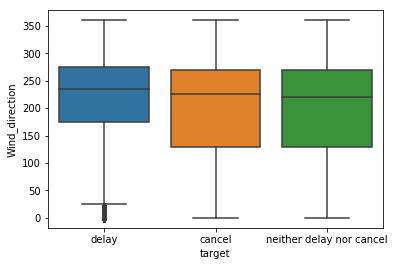

In [14]:
sns.boxplot(x="target",y="Wind_direction",data=departure_merge)

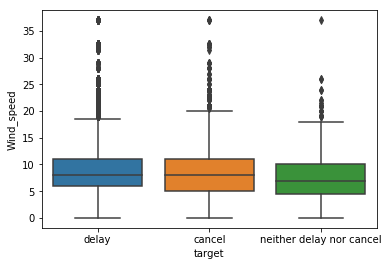

In [15]:
sns.boxplot(x="target",y="Wind_speed",data=departure_merge)

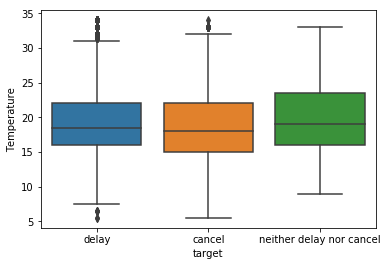

In [16]:
sns.boxplot(x="target",y="Temperature",data=departure_merge)

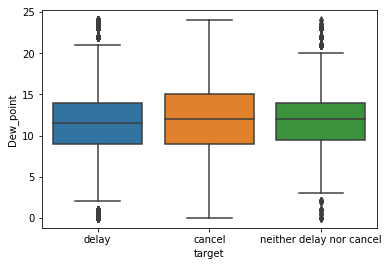

In [17]:
sns.boxplot(x="target",y="Dew_point",data=departure_merge)

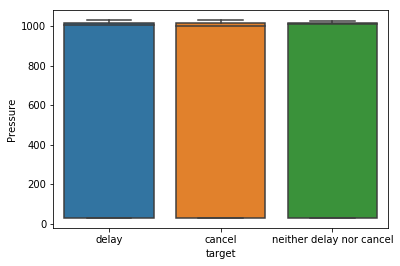

In [18]:
sns.boxplot(x="target",y="Pressure",data=departure_merge)

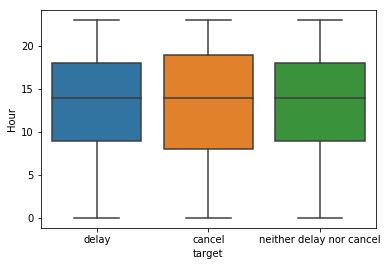

In [19]:
sns.boxplot(x="target",y="Hour",data=departure_merge)

In [20]:
catg_encod = LabelEncoder()
departure_merge["airline_name_catg"] = catg_encod.fit_transform(departure_merge["airline_name"])
departure_merge["flight_origin_name_catg"] = catg_encod.fit_transform(departure_merge["flight_origin_name"])
departure_merge["flight_destination_name_catg"] = catg_encod.fit_transform(departure_merge["flight_destination_name"])

In [21]:
departure_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121048 entries, 0 to 121047
Data columns (total 27 columns):
flight_number                   121048 non-null object
airline_name                    121048 non-null object
airline_iata                    121048 non-null object
flight_origin_code_iata         121048 non-null object
flight_origin_name              121048 non-null object
flight_destination_code_iata    121048 non-null object
flight_destination_name         121048 non-null object
flight_departure_scheduled      121048 non-null int64
flight_departure_real           121048 non-null float64
flight_arrival_scheduled        121048 non-null int64
flight_arrival_real             121048 non-null float64
target                          121048 non-null object
Hour_departures                 121048 non-null int64
Date_departures                 121048 non-null object
Hour_arrivals                   121048 non-null int64
Date_arrivals                   121048 non-null object
AIRPORT_IAT

In [22]:
clf = RandomForestClassifier(n_estimators=150, max_depth=30,random_state=0)
model = clf.fit(departure_merge[['airline_name_catg','flight_origin_name_catg','flight_destination_name_catg','Wind_direction', 'Wind_speed', 'Temperature',
                       'Dew_point', 'Pressure', 'Hour']], departure_merge['target'])

In [23]:
pred = clf.predict(departure_merge[['airline_name_catg','flight_origin_name_catg','flight_destination_name_catg','Wind_direction', 'Wind_speed', 'Temperature',
                       'Dew_point', 'Pressure', 'Hour']])

In [24]:
confusion_matrix(departure_merge['target'],pred)

array([[  4881,    331,      1],
       [    53, 113971,      5],
       [     3,     54,   1749]])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(departure_merge[['airline_name_catg','flight_origin_name_catg','flight_destination_name_catg','Wind_direction', 'Wind_speed', 'Temperature',
                                                                   'Dew_point', 'Pressure', 'Hour']], departure_merge['target']
                                                    , test_size=0.20, random_state=35)

In [26]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Tuning Random Forest Classifier  

In [27]:
# Creating the parameters list 
param_dist = {"max_depth": [3, 5,10,15,20],
              "max_features": [2,4],
              "min_samples_split": [10, 100, 500],
              "bootstrap": [True, False],
              "n_estimators": [10, 20, 30, 50, 100, 200],
              "criterion": ["gini", "entropy"]}

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,average='weighted')

# Perform random search on the classifier using the f1_scorer as the scoring method
random_obj = RandomizedSearchCV(clf, scoring=f1_scorer, param_distributions=param_dist, cv=5)

# Fit the random search object to the training data and find the optimal parameters
random_obj = random_obj.fit(X_train,y_train)

In [28]:
# Get the estimator
clf = random_obj.best_estimator_
print(random_obj.best_params_)

{'n_estimators': 10, 'min_samples_split': 10, 'max_features': 4, 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}


In [29]:
# Prediction for testing set
y_pred = clf.predict(X_test)
    
# Print the results of prediction for testing set
print("F1 score for test set: {:.4f}".format((f1_score(y_test, y_pred, average='weighted'))))
print("Accuracy for test set: {:.4f}".format((np.mean(y_test == y_pred))))

F1 score for test set: 0.9356
Accuracy for test set: 0.9491


### Accuracy for individual classes

In [30]:
confusion_matrix(y_test, y_pred, labels=['neither delay nor cancel', 'delay', 'cancel'])

array([[   15,   319,     8],
       [   16, 22682,   121],
       [    2,   767,   280]])

In [31]:
test_label = pd.DataFrame(y_test)
test_label['target predicted'] = y_pred

In [32]:
test_label_cancel = test_label[test_label.target == 'cancel']
print("Accuracy for cancel: {:.4f}".format((np.mean(test_label_cancel.target == test_label_cancel['target predicted']))))

Accuracy for cancel: 0.2669


In [33]:
test_label_delay = test_label[test_label.target == 'delay']
print("Accuracy for delay: {:.4f}".format((np.mean(test_label_delay.target == test_label_delay['target predicted']))))

Accuracy for delay: 0.9940


In [34]:
test_label_neither = test_label[test_label.target == 'neither delay nor cancel']
print("Accuracy for neither delay nor cancel: {:.4f}".format((np.mean(test_label_neither.target == test_label_neither['target predicted']))))

Accuracy for neither delay nor cancel: 0.0439
